In [1]:
%cd "/content/drive/My Drive/NTUEE_MachineLearning2020/HW2 - Classification"

!ls

/content/drive/My Drive/NTUEE_MachineLearning2020/HW2 - Classification
acc.png    data.tar.gz		     kaggle.json	    submission.csv
ANN.ipynb  hw2_classification.ipynb  loss.png
data	   HW2.ipynb		     output_generative.csv


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers

import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.2.0


In [28]:
import numpy as np

np.random.seed(0)
X_train_fpath = './data/X_train'
Y_train_fpath = './data/Y_train'
X_test_fpath = './data/X_test'
output_fpath = './output_{}.csv'

# Parse csv files to numpy array
with open(X_train_fpath) as f:
    next(f)
    X_train = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)
with open(Y_train_fpath) as f:
    next(f)
    Y_train = np.array([line.strip('\n').split(',')[1] for line in f], dtype = float)
with open(X_test_fpath) as f:
    next(f)
    X_test = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)

def _normalize(X, train = True, specified_column = None, X_mean = None, X_std = None):
    # This function normalizes specific columns of X.
    # The mean and standard variance of training data will be reused when processing testing data.
    #
    # Arguments:
    #     X: data to be processed
    #     train: 'True' when processing training data, 'False' for testing data
    #     specific_column: indexes of the columns that will be normalized. If 'None', all columns
    #         will be normalized.
    #     X_mean: mean value of training data, used when train = 'False'
    #     X_std: standard deviation of training data, used when train = 'False'
    # Outputs:
    #     X: normalized data
    #     X_mean: computed mean value of training data
    #     X_std: computed standard deviation of training data

    if specified_column == None:
        specified_column = np.arange(X.shape[1])
    if train:
        X_mean = np.mean(X[:, specified_column] ,0).reshape(1, -1)
        X_std  = np.std(X[:, specified_column], 0).reshape(1, -1)

    X[:,specified_column] = (X[:, specified_column] - X_mean) / (X_std + 1e-8)
     
    return X, X_mean, X_std

def _train_dev_split(X, Y, dev_ratio = 0.25):
    # This function spilts data into training set and development set.
    train_size = int(len(X) * (1 - dev_ratio))
    return X[:train_size], Y[:train_size], X[train_size:], Y[train_size:]

# Normalize training and testing data
X_train, X_mean, X_std = _normalize(X_train, train = True)
X_test, _, _= _normalize(X_test, train = False, specified_column = None, X_mean = X_mean, X_std = X_std)

train_size = X_train.shape[0]
test_size = X_test.shape[0]
data_dim = X_train.shape[1]
print('Size of training set: {}'.format(train_size))
print('Size of testing set: {}'.format(test_size))
print('Dimension of data: {}'.format(data_dim))

Size of training set: 54256
Size of testing set: 27622
Dimension of data: 510


In [45]:
Y_train == 1

array([ True, False, False, ..., False, False, False])

In [122]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=[len(X_train[0])]),
    keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])
adam = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])


In [123]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_15 (Flatten)         (None, 510)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 64)                32704     
_________________________________________________________________
dropout_32 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_49 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_33 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_50 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_34 (Dropout)         (None, 64)              

In [138]:
history = model.fit(X_train, Y_train, epochs=200, batch_size=32, validation_split=0.0)

Epoch 1/200
1696/1696 [==============================] - 4s 2ms/step - loss: 0.2877 - accuracy: 0.8918
Epoch 2/200
1696/1696 [==============================] - 4s 2ms/step - loss: 0.2904 - accuracy: 0.8902
Epoch 3/200
1696/1696 [==============================] - 4s 2ms/step - loss: 0.2906 - accuracy: 0.8927
Epoch 4/200
1696/1696 [==============================] - 4s 2ms/step - loss: 0.2895 - accuracy: 0.8917
Epoch 5/200
1696/1696 [==============================] - 4s 2ms/step - loss: 0.2912 - accuracy: 0.8928
Epoch 6/200
1696/1696 [==============================] - 4s 2ms/step - loss: 0.2907 - accuracy: 0.8932
Epoch 7/200
1696/1696 [==============================] - 4s 2ms/step - loss: 0.2902 - accuracy: 0.8926
Epoch 8/200
1696/1696 [==============================] - 4s 2ms/step - loss: 0.2925 - accuracy: 0.8928
Epoch 9/200
1696/1696 [==============================] - 4s 2ms/step - loss: 0.2933 - accuracy: 0.8927
Epoch 10/200
1696/1696 [==============================] - 4s 2ms/step - l

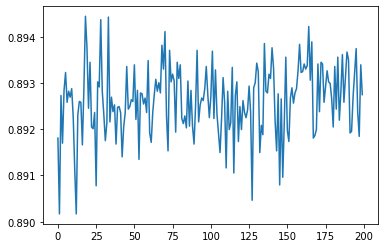

In [139]:
pd.Series(history.history['accuracy']).plot()
#pd.Series(history.history['loss']).plot()

In [140]:
test_predictions = np.round(model.predict(X_test))
test_predictions = test_predictions.reshape(-1).astype(int)

In [142]:
# Predict testing labels
#predictions = _predict(X_test, w, b)
with open(output_fpath.format('dnn'), 'w') as f:
    f.write('id,label\n')
    for i, label in  enumerate(test_predictions):
        f.write('{},{}\n'.format(i, label))



In [62]:
!gdown --id 1VoF-D1FH0PhIne0pdDMKNmSg-SXfBoKS
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json

Downloading...
From: https://drive.google.com/uc?id=1VoF-D1FH0PhIne0pdDMKNmSg-SXfBoKS
To: /content/drive/My Drive/NTUEE_MachineLearning2020/HW2 - Classification/kaggle.json
100% 65.0/65.0 [00:00<00:00, 58.5kB/s]
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [143]:
!kaggle competitions submit -c ml2020spring-hw2 -f output_dnn.csv -m "Message"

100% 205k/205k [00:00<00:00, 792kB/s]
Successfully submitted to ML2020spring - hw2